# One vs One Analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import math
import cv2
import gkpose as gk
import ast
import re

In [2]:
mpii_edges = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5], 
              [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15], 
              [6, 8], [8, 9]]

## Import Data

In [3]:
#Import 3D keypoints - set
set_3d_df = pd.read_csv('../1v1Data/set_3d.csv', index_col=0)
set_3d_df = gk.getPhotoID(set_3d_df)

In [4]:
#Import 2D keypoints - set
set_2d_df = pd.read_csv('../1v1Data/set_2d.csv', index_col=0)
set_2d_df = gk.getPhotoID(set_2d_df)

In [5]:
#Import StatsBomb 1v1 Data
converter = {
    'location':ast.literal_eval,
    'shot_end_location':ast.literal_eval,
    'shot_freeze_frame':ast.literal_eval
}
sb_df = pd.read_csv('../StatsBomb/1v1s.csv', index_col=0, converters = converter)

In [6]:
sb_df.head()

index  minute  second  duration play_pattern_name team_name       location  \
0    928      26      31     0.240      Regular Play   Denmark  [111.0, 50.0]   
1   2452      57      48     0.213      Regular Play    Poland  [110.0, 29.0]   
2   2939      69       2     0.667      Regular Play  Colombia  [108.0, 47.0]   
3   3093      74      42     0.827      From Counter  Colombia  [105.0, 38.0]   
4   3211      80       9     0.453       From Corner    Poland  [116.0, 33.0]   

   player_id                     player_name under_pressure  ...  \
0     4447.0  Martin Braithwaite Christensen           True  ...   
1     5668.0              Robert Lewandowski            NaN  ...   
2     3445.0    Radamel Falcao García Zárate            NaN  ...   
3     5689.0   Juan Guillermo Cuadrado Bello            NaN  ...   
4     3637.0             Grzegorz Krychowiak            NaN  ...   

  shot_technique_name                                  shot_freeze_frame  \
0              Normal  [{'location': [116.0, 45.0], 'player': {'id': ...   
1              Normal  [{'location': [112.0, 31.0], 'player': {'id': ...   
2              Normal  [{'location': [99.0, 31.0], 'player': {'id': 5...   
3              Normal  [{'location': [102.0, 40.0], 'player': {'id': ...   
4              Normal  [{'location': [118.0, 36.0], 'player': {'id': ...   

  shot_first_time                      shot_key_pass_id match_id onevone  \
0            True  d53d0a84-d3f0-482d-9164-d5e81fdddb6c     7581    True   
1             NaN  1b4557cb-60c5-4839-8fd4-842b710f36e2     7555    True   
2             NaN  d857ceeb-9ae4-4476-aeb8-dcde864b5da0     7555    True   
3             NaN  92c3fad5-88de-46bf-93a0-d609cd7d2fbc     7555    True   
4             NaN                                   NaN     7555    True   

   match_date  home_team_home_team_name  away_team_away_team_name  \
0  2018-07-01                   Croatia                   Denmark   
1  2018-06-24                    Poland                  Colombia   
2  2018-06-24                    Poland                  Colombia   
3  2018-06-24                    Poland                  Colombia   
4  2018-06-24                    Poland                  Colombia   

               event_path  
0  open-data/data/events/  
1  open-data/data/events/  
2  open-data/data/events/  
3  open-data/data/events/  
4  open-data/data/events/  

[5 rows x 23 columns]

In [7]:
#Get assist type feature
type_arr = ['Other'] * len(sb_df)
for i in range(len(sb_df)):
    kp_id = sb_df['shot_key_pass_id'][i]
    if type(kp_id) == str:
        path = '../StatsBomb/' + sb_df['event_path'][i]
        file = str(sb_df['match_id'][i]) + '.json'
        events = gk.importSBjson(file, path)
        kp_df = events.loc[events['id'] == kp_id, :].reset_index(drop=True)
        if kp_df['pass_cross'][0] == True:
            type_name = 'Cross'
        else:
            type_name = 'Pass'
        type_arr[i] = type_name
    #print(i)
sb_df['assist_type'] = np.array(type_arr)

In [9]:
sb_df.to_csv('1v1s_with_assists.csv', index=False)

In [10]:
#Import StatsBomb 1v1 Data
converter = {
    'location':ast.literal_eval,
    'shot_end_location':ast.literal_eval,
    'shot_freeze_frame':ast.literal_eval
}
sb_df = pd.read_csv('1v1s_with_assists.csv', converters = converter)

In [12]:
#Get features of each one v one. 
#Can add key pass features later
location_x = []
location_y = []
goalkeeper_x = []
goalkeeper_y = []
striker_distance_to_goal = []
shot_angle = []
gk_engage = []
gk_names = []
for i in range(len(sb_df)):
    shooter_x,shooter_y,_,_,_,_,gk_x,gk_y,is_gk = gk.getFreezeFrame(sb_df, shot_id=i)
    player_names = []
    for p in range(len(sb_df.loc[i,'shot_freeze_frame'])):
        player_names.append(sb_df.loc[i,'shot_freeze_frame'][p]['player']['name'])
    gk_names.append(np.array(player_names)[is_gk.astype(bool)][0])
    location_x.append(shooter_x)
    location_y.append(shooter_y)
    goalkeeper_x.append(gk_x[0])
    goalkeeper_y.append(gk_y[0])
    shot_dist = gk.distance_to_goal(shooter_x, shooter_y)
    striker_distance_to_goal.append(shot_dist) #shot distance to goal
    shot_angle.append(gk.goal_angle(shooter_x, shooter_y)) #shot angle
    gk_striker_dist = gk.distance_to_goal(shooter_x, shooter_y, gk_x[0], gk_y[0])
    gk_engage.append(gk_striker_dist / shot_dist) #Goalkeeper engagement metric
    
#add features to dataframe
sb_df['shooter_x'] = location_x
sb_df['shooter_y'] = location_y
sb_df['goalkeeper_x'] = goalkeeper_x
sb_df['goalkeeper_y'] = goalkeeper_y
sb_df['distance_to_goal'] = striker_distance_to_goal
sb_df['shot_angle'] = shot_angle
sb_df['gk_engage'] = gk_engage
sb_df['gk_name'] = gk_names

#Clean df
sb_df['shot_first_time'] = sb_df['shot_first_time'].fillna(False).astype(int)
sb_df['under_pressure'] = sb_df['under_pressure'].fillna(False).astype(int)
sb_df.loc[sb_df['duration'] > 20, 'duration'] = np.mean(sb_df['duration'])

#Keep only selected features
sb_df = sb_df[['duration','play_pattern_name','under_pressure','shot_outcome_name',
               'shot_first_time','distance_to_goal','shot_angle','gk_name','gk_engage',
               'assist_type','player_name']].copy()

In [13]:
sb_df.head()

duration play_pattern_name  under_pressure shot_outcome_name  \
0     0.240      Regular Play               1             Saved   
1     0.213      Regular Play               0             Saved   
2     0.667      Regular Play               0              Goal   
3     0.827      From Counter               0              Goal   
4     0.453       From Corner               0           Blocked   

   shot_first_time  distance_to_goal  shot_angle               gk_name  \
0                1         13.453624   48.012788       Danijel Subašić   
1                0         14.866069   47.726311  David Ospina Ramírez   
2                0         13.892444   30.256437     Wojciech Szczęsny   
3                0         15.132746    7.594643     Wojciech Szczęsny   
4                0          8.062258   60.255119  David Ospina Ramírez   

   gk_engage assist_type                     player_name  
0   0.525588        Pass  Martin Braithwaite Christensen  
1   0.190261        Pass              Robert Lewandowski  
2   0.580334        Pass    Radamel Falcao García Zárate  
3   0.738818        Pass   Juan Guillermo Cuadrado Bello  
4   0.447214       Other             Grzegorz Krychowiak

In [95]:
set_3d_df.head()

0         1         2         3         4         5         6  \
0 -0.187500  0.281250 -0.015079 -0.140625  0.140625  0.169988 -0.046875   
1  0.171875  0.281250  0.033766  0.187500  0.140625  0.152587  0.031250   
2 -0.093750  0.359375  0.016994  0.015625  0.234375  0.005835 -0.031250   
3 -0.156250  0.390625 -0.044468 -0.140625  0.171875  0.159150 -0.046875   
4 -0.125000  0.406250 -0.001968 -0.125000  0.203125  0.166595 -0.062500   

          7         8         9  ...       40        41        42        43  \
0 -0.015625 -0.012308  0.046875  ... -0.21875 -0.011179  0.203125 -0.093750   
1  0.000000 -0.045793 -0.031250  ... -0.21875  0.033514  0.031250 -0.093750   
2  0.015625 -0.043475  0.046875  ... -0.15625 -0.072264  0.234375 -0.046875   
3  0.000000 -0.028738  0.062500  ... -0.34375 -0.019926  0.234375 -0.234375   
4  0.000000 -0.005656  0.078125  ... -0.28125 -0.014175  0.140625 -0.234375   

         44        45        46        47       file  photo_id  
0  0.066936  0.281250  0.000000  0.089892  382-2.png       382  
1  0.138639  0.109375 -0.031250  0.116491  262-2.png       262  
2 -0.004875  0.281250  0.062500 -0.011386  537-2.png       537  
3  0.068202  0.359375 -0.140625  0.027107  476-2.png       476  
4  0.037226  0.140625 -0.109375  0.019169     63.png        63  

[5 rows x 50 columns]

In [14]:
#Merge set_3d_df (file) with sb_df (index)
set_3d_df = set_3d_df.merge(sb_df, left_on='photo_id', right_index=True, how='left')
set_2d_df = set_2d_df.merge(sb_df, left_on='photo_id', right_index=True, how='left')

In [15]:
set_3d_df.head()

0         1         2         3         4         5         6  \
0 -0.187500  0.281250 -0.015079 -0.140625  0.140625  0.169988 -0.046875   
1  0.171875  0.281250  0.033766  0.187500  0.140625  0.152587  0.031250   
2 -0.093750  0.359375  0.016994  0.015625  0.234375  0.005835 -0.031250   
3 -0.156250  0.390625 -0.044468 -0.140625  0.171875  0.159150 -0.046875   
4 -0.125000  0.406250 -0.001968 -0.125000  0.203125  0.166595 -0.062500   

          7         8         9  ...  play_pattern_name  under_pressure  \
0 -0.015625 -0.012308  0.046875  ...     From Free Kick               0   
1  0.000000 -0.045793 -0.031250  ...      From Throw In               1   
2  0.015625 -0.043475  0.046875  ...      From Throw In               0   
3  0.000000 -0.028738  0.062500  ...       Regular Play               0   
4  0.000000 -0.005656  0.078125  ...     From Free Kick               0   

   shot_outcome_name  shot_first_time  distance_to_goal  shot_angle  \
0              Saved                0          7.280110   74.054604   
1               Goal                0         11.180340   63.434949   
2               Goal                0         11.313708   45.000000   
3              Saved                0         12.041595    4.763642   
4               Goal                1          8.485281   45.000000   

          gk_name  gk_engage  assist_type                player_name  
0     Jonas Lössl   0.566352        Other              Ashley Barnes  
1     Hugo Lloris   0.644981         Pass   Lucas Torreira Di Pascua  
2     Mathew Ryan   1.000000         Pass  Pierre-Emerick Aubameyang  
3      Tom Heaton   0.332182         Pass   Daniel William John Ings  
4  Eiji Kawashima   0.687184         Pass               Jan Bednarek  

[5 rows x 61 columns]

In [16]:
sets_3d = set_3d_df.loc[:,'0':'47'].values
print(sets_3d.shape)

(590, 48)


In [17]:
sets_2d = set_2d_df.loc[:,'0':'31'].values
print(sets_2d.shape)

(590, 32)


## Camera-view Invariant Dataset

In [19]:
#Get camera-view invariant dataset of 3d poses
cvi_arr = gk.cameraInvariantDataset(sets_3d)

In [20]:
#Rotates the poses from images taken from behind by 180 degrees
sets_3d_cvi = gk.flipBehindPoses(cvi_arr)

In [21]:
np.where(set_3d_df['photo_id'] == 10)[0]

array([74])

In [22]:
#Create the cvi sets dataframe
set_3d_cvi_df = pd.DataFrame(sets_3d_cvi)
set_3d_cvi_df.columns = set_3d_cvi_df.columns.astype(str)
cols = ['file', 'photo_id', 'duration', 'play_pattern_name', 'under_pressure',
       'shot_outcome_name', 'shot_first_time', 'distance_to_goal',
       'shot_angle', 'gk_name', 'gk_engage', 'assist_type']
set_3d_cvi_df[cols] = set_3d_df[cols]

In [23]:
#Create cvi set array with gk_engage metric included
keep_cols = np.array(list(range(48)) + ['gk_engage'])
sets_3d_cvi = set_3d_cvi_df.loc[:,keep_cols].values
print(sets_3d_cvi.shape)

(590, 49)


In [24]:
set_3d_cvi_df.head()

0         1         2         3         4         5         6  \
0 -0.187270  0.281250  0.017709 -0.108971  0.140625  0.191825 -0.048300   
1 -0.084613  0.281250 -0.153368 -0.003635  0.140625 -0.241714 -0.055167   
2 -0.047243  0.359375  0.082741  0.014513  0.234375 -0.008219 -0.053391   
3 -0.157551  0.390625  0.039614 -0.042210  0.171875  0.208141 -0.054964   
4 -0.125000  0.406250 -0.001968 -0.125000  0.203125  0.166595 -0.062500   

          7         8         9  ...  duration  play_pattern_name  \
0 -0.015625 -0.003981  0.047579  ...  0.186800     From Free Kick   
1  0.000000  0.005496  0.049572  ...  0.454694      From Throw In   
2  0.015625 -0.004006  0.063689  ...  0.771300      From Throw In   
3  0.000000 -0.001450  0.065672  ...  0.714875       Regular Play   
4  0.000000 -0.005656  0.078125  ...  0.533000     From Free Kick   

   under_pressure  shot_outcome_name  shot_first_time  distance_to_goal  \
0               0              Saved                0          7.280110   
1               1               Goal                0         11.180340   
2               0               Goal                0         11.313708   
3               0              Saved                0         12.041595   
4               0               Goal                1          8.485281   

   shot_angle         gk_name  gk_engage  assist_type  
0   74.054604     Jonas Lössl   0.566352        Other  
1   63.434949     Hugo Lloris   0.644981         Pass  
2   45.000000     Mathew Ryan   1.000000         Pass  
3    4.763642      Tom Heaton   0.332182         Pass  
4   45.000000  Eiji Kawashima   0.687184         Pass  

[5 rows x 60 columns]

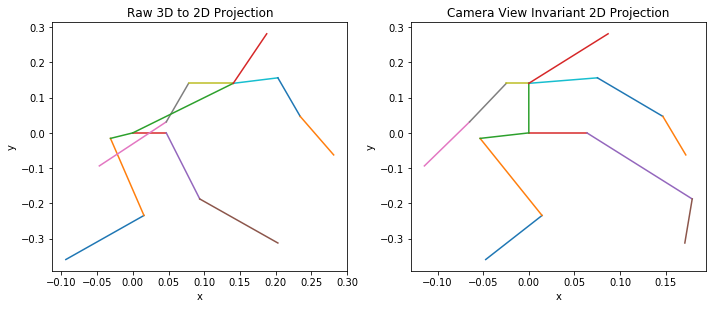

In [20]:
pose_id = 2
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(2, 2, 1)
gk.plot2D(ax, gk.pose_to_matrix(sets_3d[pose_id]), mpii_edges)
ax.set_title('Raw 3D to 2D Projection')
ax = fig.add_subplot(2, 2, 2)
gk.plot2D(ax, gk.pose_to_matrix(sets_3d_cvi[pose_id][:-1]), mpii_edges)
ax.set_title('Camera View Invariant 2D Projection')
plt.tight_layout()
plt.show()

## Remove Bad Pose Predictions

Array ID: 1
File Name: 262-2.png


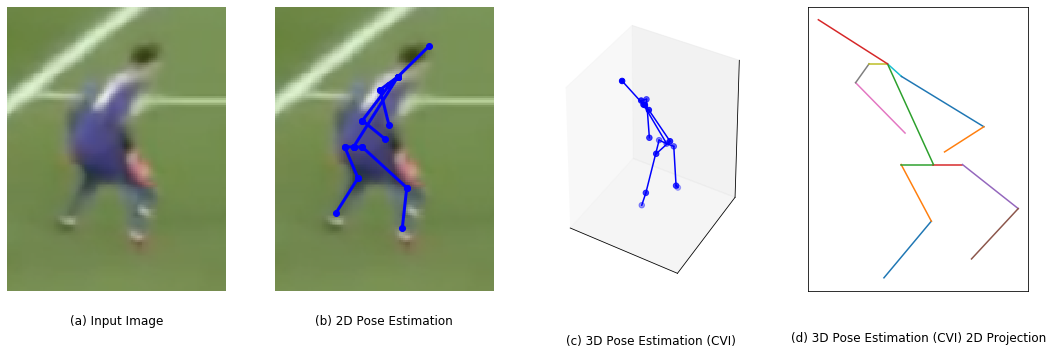

In [21]:
array_id = 1
gk.plot2D3DPose(array_id, set_3d_df, sets_2d, sets_3d_cvi, '../1v1Data/set/', mpii_edges)

In [25]:
#List of the array_ids in which to remove because they are bad prediction of true pose
#Removed based on the CVI 2D projection
to_remove_sets = np.array([1,6,7,11,14,25,27,28,31,32,37,40,42,43,44,51,52,53,55,58,
                           63,65,72,81,83,85,87,94,96,108,109,110,113,114,116,117,119,
                           123,131,133,135,136,137,140,141,143,144,147,150,151,154,156,
                           157,159,160,161,163,167,170,176,189,193,195,196,198,200,
                           202,203,206,207,210,211,213,216,217,218,220,227,228,235,
                           237,238,242,243,244,245,250,251,252,255,261,262,267,268,
                           270,271,274,275,276,282,287,291,296,297,298,304,305,311,312,
                           316,320,323,324,326,327,328,333,334,335,341,350,351,352,370,
                           372,374,379,387,388,389,390,395,397,401,406,411,413,414,418,
                           419,423,433,436,439,443,446,451,452,453,456,462,465,470,472,
                           474,475,480,489,490,494,502,507,509,515,517,522,528,532,533,
                           537,553,555,558,566,567,570,572,575,579,580,585,])
print("Removing " + str(len(to_remove_sets)) + " of " + 
      str(len(sets_3d_cvi)) + " poses, " + str(100*np.round(len(to_remove_sets)/len(sets_3d_cvi), 2)) + "%")

Removing 181 of 590 poses, 31.0%


In [26]:
#Remove selected poses
set_3d_cvi_clean_df = set_3d_cvi_df.drop(to_remove_sets).reset_index(drop=True)
keep_cols = np.array(list(range(48)) + ['gk_engage'])
sets_3d_cvi_clean = set_3d_cvi_clean_df.loc[:,keep_cols].values
print(sets_3d_cvi_clean.shape)

(409, 49)


In [29]:
set_3d_cvi_clean_df.head()

0         1         2         3         4         5         6  \
0 -0.187270  0.281250  0.017709 -0.108971  0.140625  0.191825 -0.048300   
1 -0.047243  0.359375  0.082741  0.014513  0.234375 -0.008219 -0.053391   
2 -0.157551  0.390625  0.039614 -0.042210  0.171875  0.208141 -0.054964   
3 -0.125000  0.406250 -0.001968 -0.125000  0.203125  0.166595 -0.062500   
4 -0.239494  0.421875 -0.098506 -0.096871  0.156250 -0.189457 -0.063936   

          7         8         9  ...  duration  play_pattern_name  \
0 -0.015625 -0.003981  0.047579  ...  0.186800     From Free Kick   
1  0.015625 -0.004006  0.063689  ...  0.771300      From Throw In   
2  0.000000 -0.001450  0.065672  ...  0.714875       Regular Play   
3  0.000000 -0.005656  0.078125  ...  0.533000     From Free Kick   
4  0.000000 -0.002673  0.079056  ...  0.960000       Regular Play   

   under_pressure  shot_outcome_name  shot_first_time  distance_to_goal  \
0               0              Saved                0          7.280110   
1               0               Goal                0         11.313708   
2               0              Saved                0         12.041595   
3               0               Goal                1          8.485281   
4               1              Off T                0         20.248457   

   shot_angle         gk_name  gk_engage  assist_type  
0   74.054604     Jonas Lössl   0.566352        Other  
1   45.000000     Mathew Ryan   1.000000         Pass  
2    4.763642      Tom Heaton   0.332182         Pass  
3   45.000000  Eiji Kawashima   0.687184         Pass  
4   57.094757     Hugo Lloris   0.931822         Pass  

[5 rows x 60 columns]

In [117]:
#set_3d_cvi_clean_df.loc[:, 'file':].to_csv('ml/raw_df.csv', index=False)

## Visualisations / Analysis

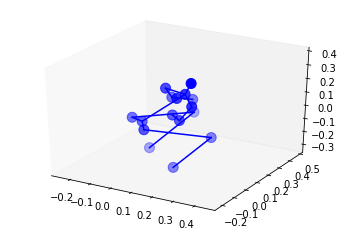

In [25]:
%matplotlib inline
points = gk.pose_to_matrix(sets_3d[189])
fig = plt.figure()
ax = fig.add_subplot((111),projection='3d')
gk.plot3D(ax, points, edges=mpii_edges)
plt.show()

## Unsupervised Learning
Body Pose Datasets:
* sets_3d_cvi_clean : 3D Camera-view invariant, bad poses removed, gk engagement metric
* sets_2d_proj : 3D-2D projection onto x-y, CVI, bad poses removed, gk engagement metric
* sets_3d_cvi : 3D Camera-view invariant, gk engagement metric
* sets_3d : Raw 3D Body Pose
* sets_2d : Raw 2D Body Pose in image coordinates

In [30]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

### Sets: 3D - 2D Projection
* This had been giving two clear clusters - but these were just images that were from in front and from behind. Therefore we need a further cleaning step where we flip body poses where the image was taken from behind
* After rotating the behind photos and trying again, the 2 clusters are quite distinctly engagements, and sets (wait and react). However, we know from domain knowledge that more techniques exist than this. So, try a higher number of cluster centres.

In [119]:
#Create 3D - 2D projection dataset
to_delete = np.array([ x-1 for x in range(0,49) if x%3==0][1:])
sets_2d_proj = np.delete(sets_3d_cvi_clean, to_delete, 1)

In [26]:
sil, iner = gk.silhouetteInertia(sets_2d_proj)

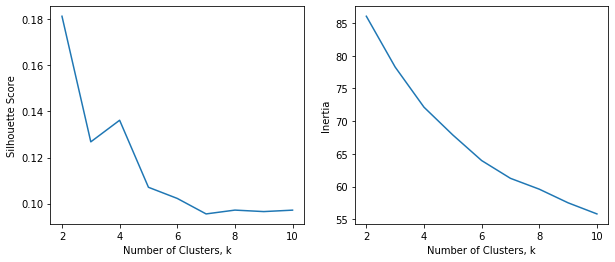

In [27]:
gk.plotSilIner(sil, iner, save='1v1s/sil_iner_2d_proj')

#### k = 2

In [49]:
k=2
kmeans_clusters2 = gk.getKMeans(sets_2d_proj, k=k)
gmm_clusters2 = gk.getGMM(sets_2d_proj, k=k)
hier_clusters2 = gk.getHier(sets_2d_proj, k=k)

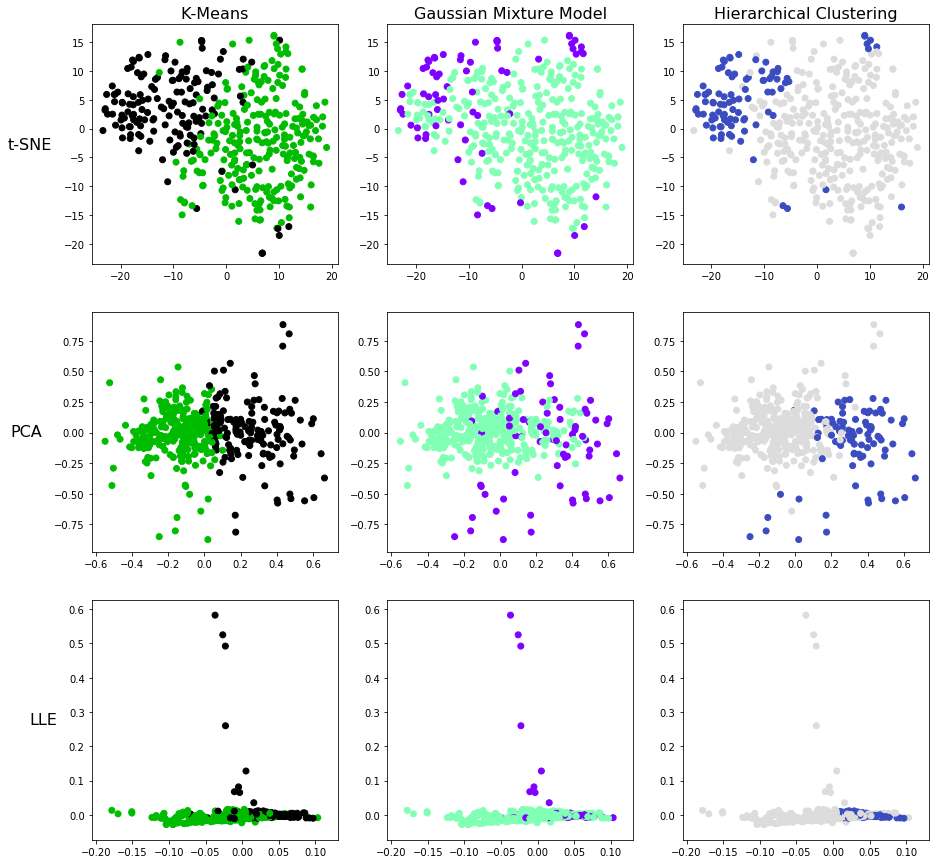

In [29]:
gk.plotManifold(sets_2d_proj, kmeans_clusters2, gmm_clusters2,
             hier_clusters2, k=k, save='1v1s/2d_proj_clusters_k2')

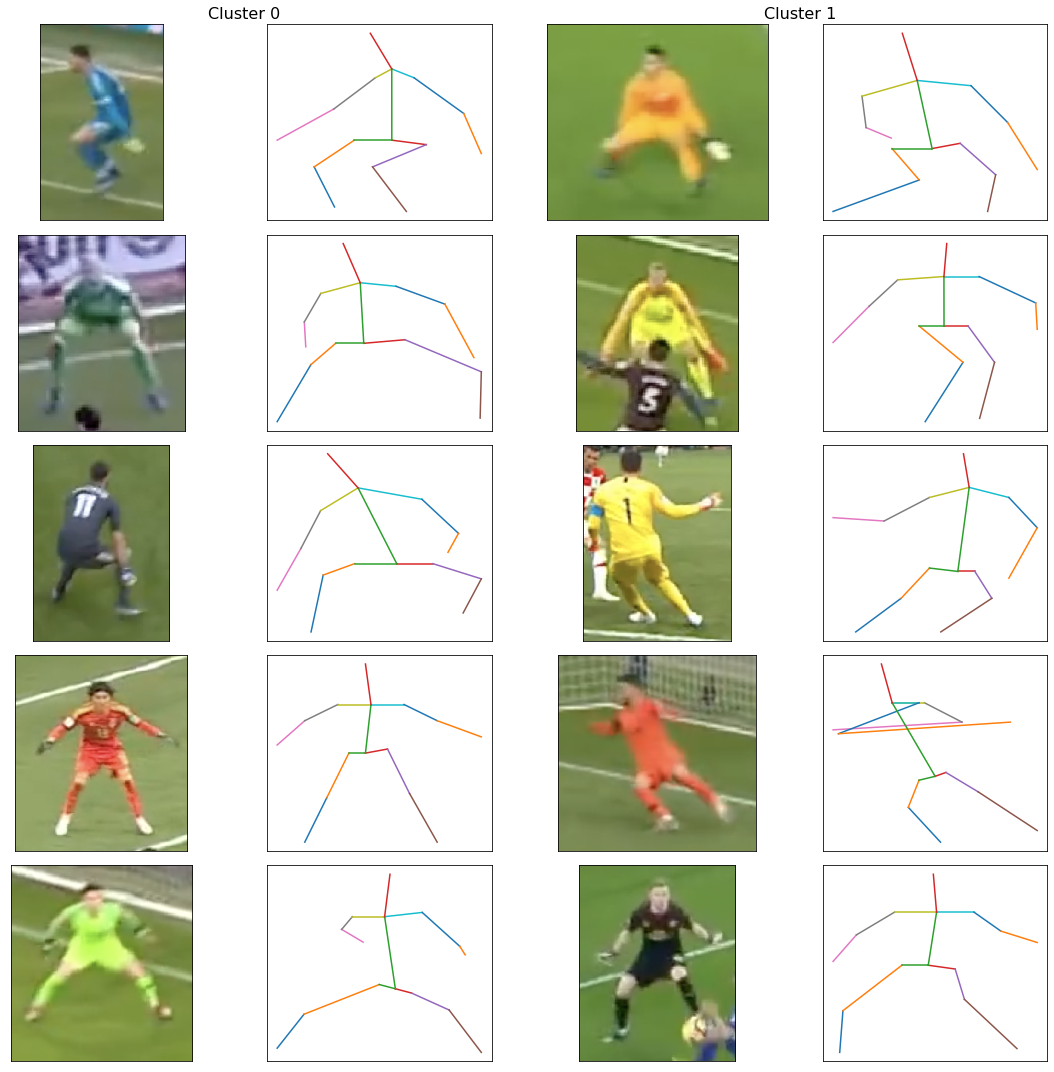

In [50]:
gk.clusterExamples(k, 5, '../1v1Data/set/', kmeans_clusters2, set_3d_cvi_clean_df, sets_3d_cvi_clean, mpii_edges, '1v1s/2d_proj_clusters_examples_k2')

In [31]:
#Difference in mean gk engagement metric between 2 clusters
print(np.mean(set_3d_cvi_clean_df.loc[kmeans_clusters2 == 0, 'gk_engage']))
print(np.mean(set_3d_cvi_clean_df.loc[kmeans_clusters2 == 1, 'gk_engage']))

0.38816964013752436
0.7406665208648272


In [62]:
np.array(ImageID(set_3d_cvi_clean_df, np.where(kmeans_clusters2 == 0)[0]))

array(['406.png', '360.png', '474-2.png', '318-3.png', '175.png',
       '364-2.png', '148.png', '177.png', '324.png', '171.png', '64.png',
       '360-2.png', '494-2.png', '494-3.png', '428.png', '410.png',
       '167-2.png', '172.png', '73.png', '239.png', '390-5.png',
       '453-2.png', '470.png', '316.png', '114.png', '262.png', '289.png',
       '505.png', '184-2.png', '179-2.png', '317.png', '459.png',
       '416.png', '473-2.png', '517.png', '182-2.png', '463.png',
       '315.png', '324-4.png', '16.png', '434-2.png', '410-2.png',
       '385-2.png', '434-3.png', '409-3.png', '345-2.png', '468-2.png',
       '13.png', '267-2.png', '280.png', '438-2.png', '109-2.png',
       '421-3.png', '336.png', '313.png', '461.png', '138-2.png',
       '239-2.png', '409-2.png', '324-2.png', '378-2.png', '267.png',
       '484.png', '237-3.png', '309.png', '479.png', '445.png', '109.png',
       '349-2.png', '464-2.png', '168-2.png', '243.png', '245.png',
       '536.png', '390-4.png', '330

#### k = 3

In [33]:
k=3
kmeans_clusters3 = gk.getKMeans(sets_2d_proj, k=k)
gmm_clusters3 = gk.getGMM(sets_2d_proj, k=k)
hier_clusters3 = gk.getHier(sets_2d_proj, k=k)

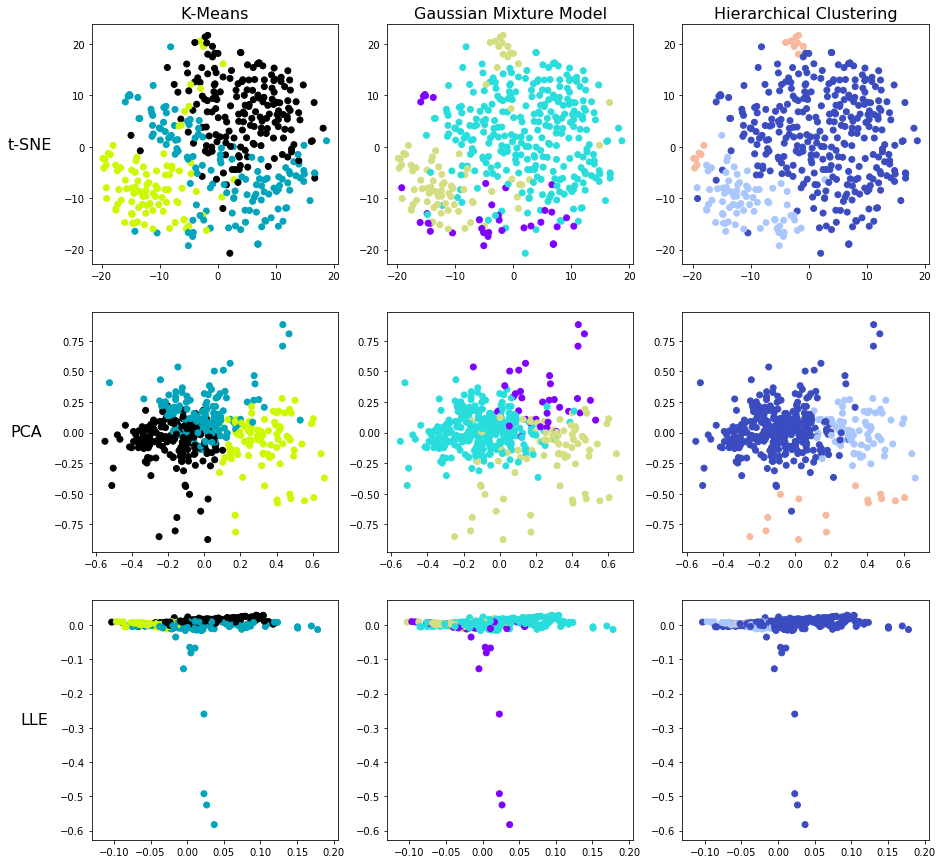

In [34]:
gk.plotManifold(sets_2d_proj, kmeans_clusters3, gmm_clusters3,
             hier_clusters3, k=k, save='1v1s/2d_proj_clusters_k3')

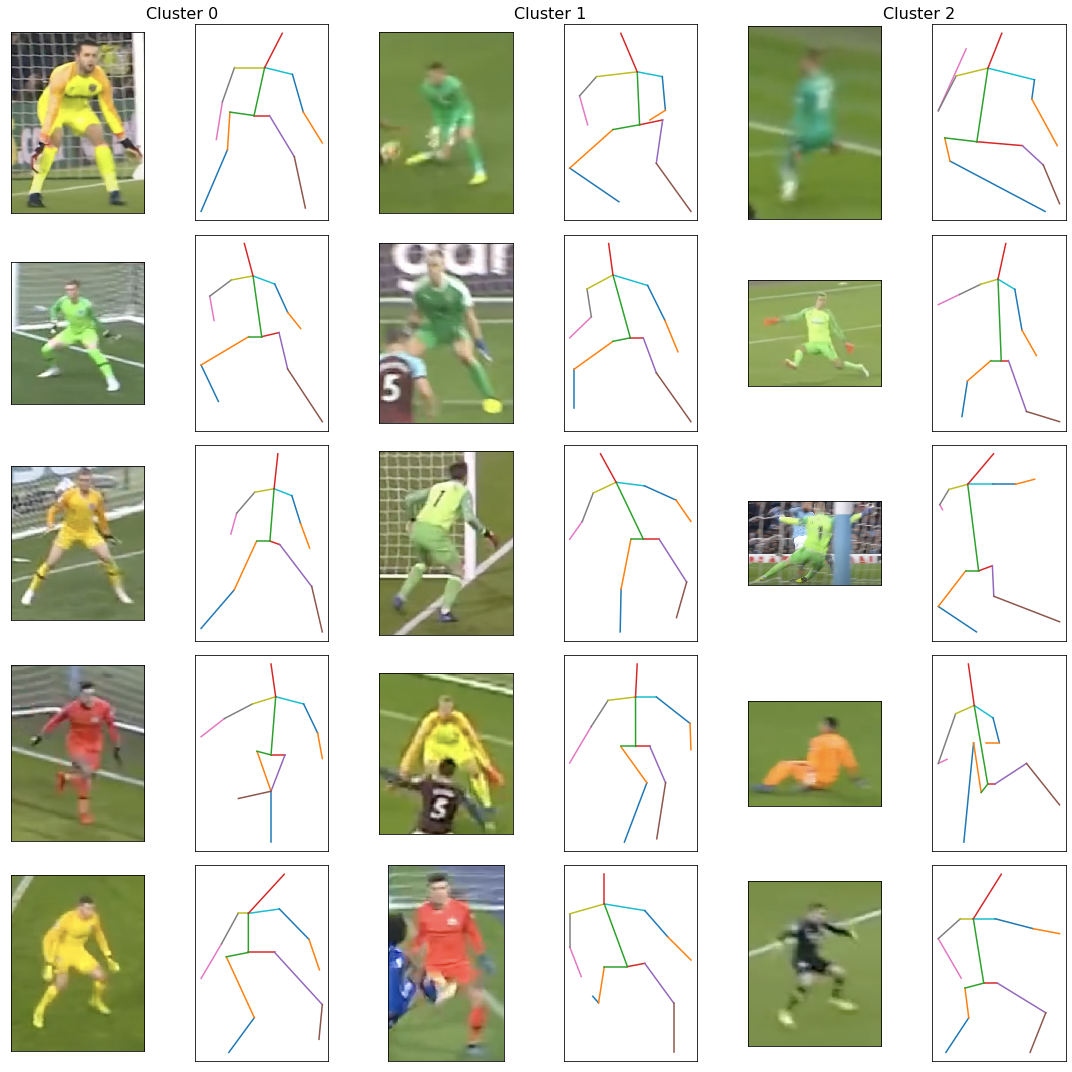

In [46]:
gk.clusterExamples(k, 5, '../1v1Data/set/', kmeans_clusters3, set_3d_cvi_clean_df, sets_3d_cvi_clean, mpii_edges, '1v1s/2d_proj_clusters_examples_k3')

In [47]:
#Difference in mean gk engagement metric between 2 clusters
print(np.mean(set_3d_cvi_clean_df.loc[kmeans_clusters3 == 0, 'gk_engage']))
print(np.mean(set_3d_cvi_clean_df.loc[kmeans_clusters3 == 1, 'gk_engage']))
print(np.mean(set_3d_cvi_clean_df.loc[kmeans_clusters3 == 2, 'gk_engage']))

0.7571446206799228
0.5842817730152535
0.35948242433375155


#### k =4

In [120]:
k=4
kmeans_clusters4 = gk.getKMeans(sets_2d_proj, k=k)
gmm_clusters4 = gk.getGMM(sets_2d_proj, k=k)
hier_clusters4 = gk.getHier(sets_2d_proj, k=k)

In [36]:
def saveClusters(clusters, file_name):
    pd.DataFrame(clusters, columns=['cluster']).to_csv('ml/' + file_name + '.csv', index=False)

In [128]:
saveClusters(kmeans_clusters4, file_name='kmeans_2d_k4')

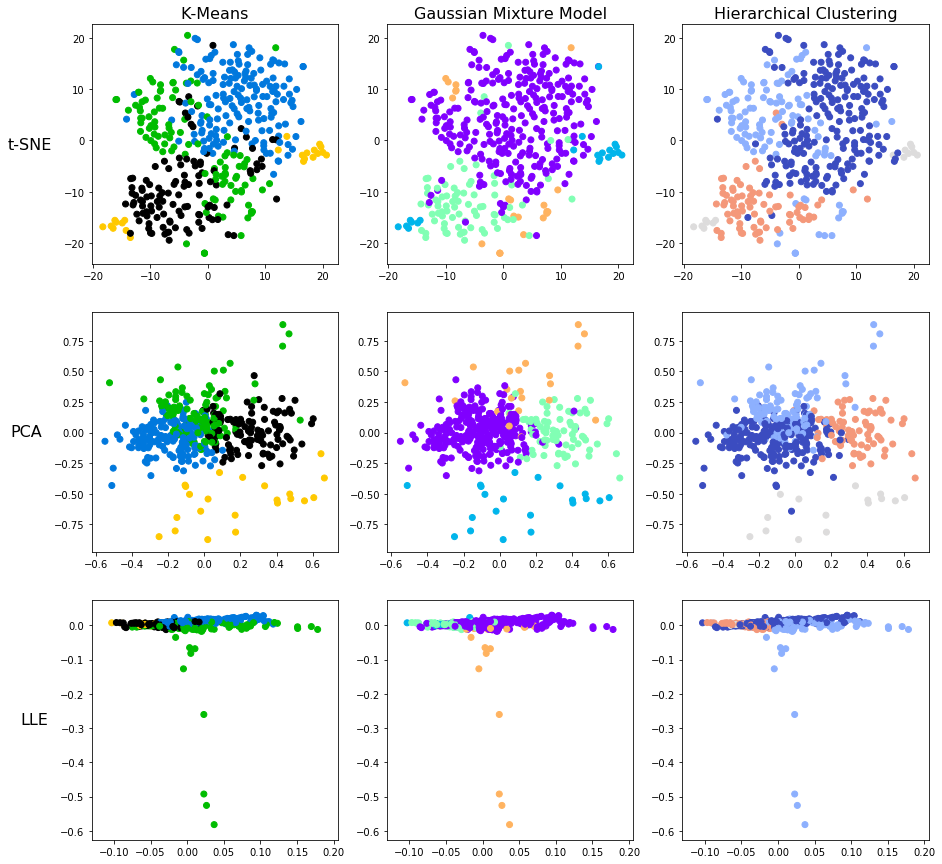

In [121]:
gk.plotManifold(sets_2d_proj, kmeans_clusters4, gmm_clusters4,
             hier_clusters4, k=k, save='1v1s/2d_proj_clusters_k4')

The clusters given with k=4 seem to correspond to passive sets, engage and spread, more aggressive sets, and smothers.

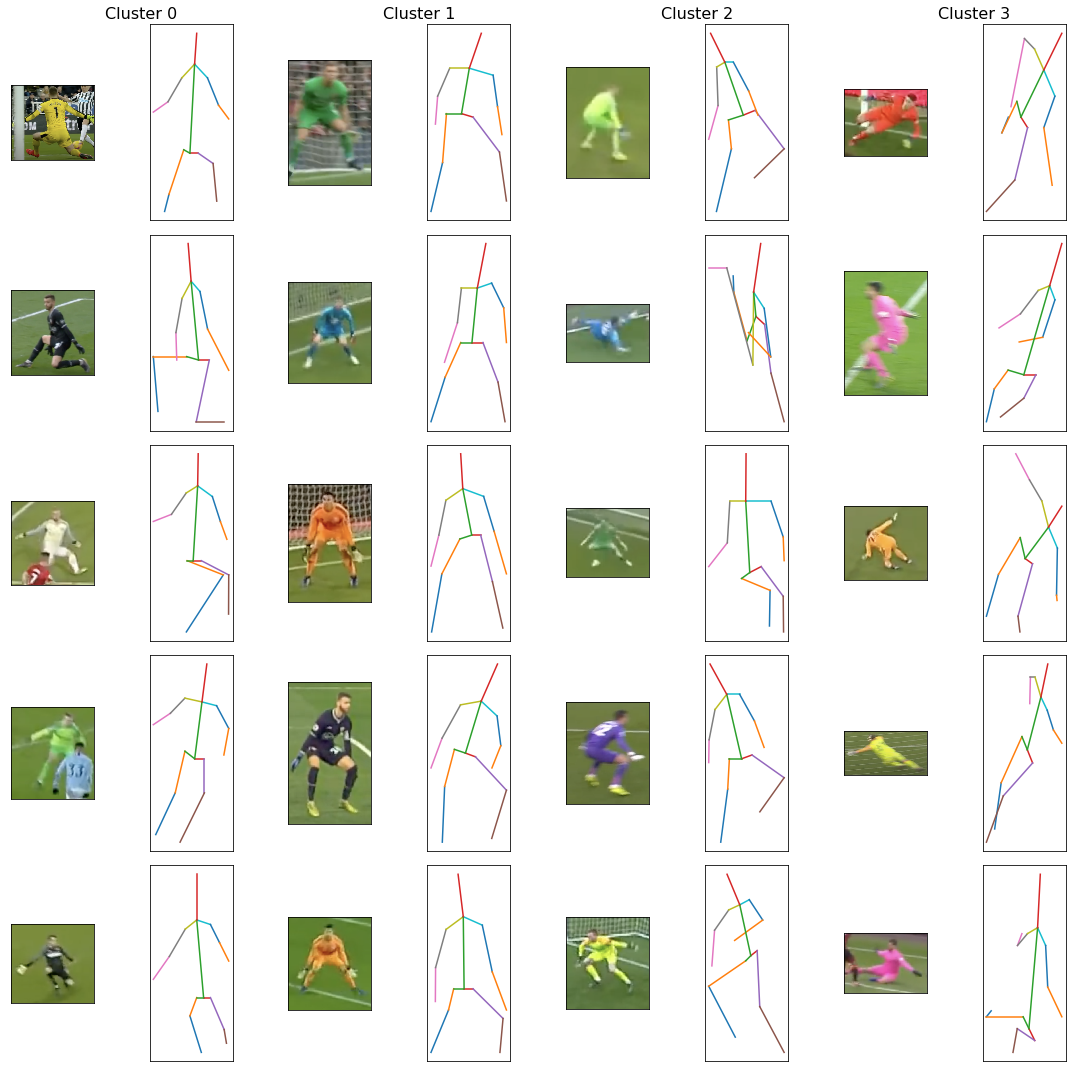

In [122]:
gk.clusterExamples(k, 5, '../1v1Data/set/', kmeans_clusters4, set_3d_cvi_clean_df, sets_3d_cvi_clean, mpii_edges, '1v1s/2d_proj_clusters_examples_k4_test')

In [123]:
#Difference in mean gk engagement metric between 2 clusters
print(np.mean(set_3d_cvi_clean_df.loc[kmeans_clusters4 == 0, 'gk_engage']))
print(np.mean(set_3d_cvi_clean_df.loc[kmeans_clusters4 == 1, 'gk_engage']))
print(np.mean(set_3d_cvi_clean_df.loc[kmeans_clusters4 == 2, 'gk_engage']))
print(np.mean(set_3d_cvi_clean_df.loc[kmeans_clusters4 == 3, 'gk_engage']))

0.3928447080362217
0.7673005493668174
0.6152814897655027
0.5132434602321104


### Sets: Feature Space

In [31]:
#Remove gk engagement metric for now
poses_noeng = sets_3d_cvi_clean[:,:-1]

In [32]:
#Poses in feature space array
poses_fs = gk.PosesFeatureSpace(poses_noeng)

In [33]:
#Add GK engagement metric back to array
fs_df = pd.DataFrame(poses_fs)
fs_df['gk_eng'] = sets_3d_cvi_clean[:,-1]
poses_fs = fs_df.values

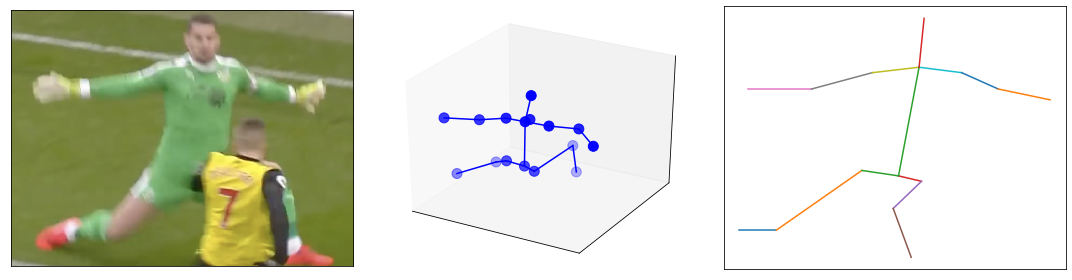

In [229]:
arr_id = 42
points = gk.pose_to_matrix(sets_3d_cvi_clean[:,:-1][arr_id])
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot((131))
ax.imshow(gk.importImage('../1v1Data/set/' + gk.ImageID(set_3d_cvi_clean_df, arr_id)))
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot((132),projection='3d')
gk.plot3D(ax, points, edges=mpii_edges)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax = fig.add_subplot((133))
gk.plot2D(ax, points, mpii_edges)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [73]:
sil, iner = gk.silhouetteInertia(poses_fs)

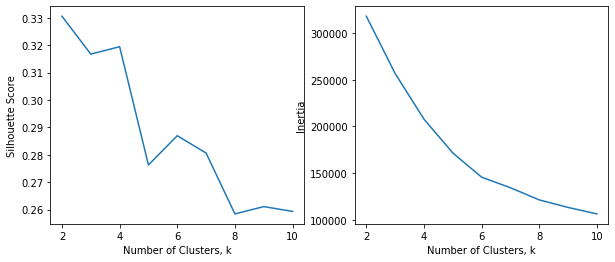

In [74]:
gk.plotSilIner(sil, iner, save='1v1s/sil_iner_feat')

##### k = 2

In [39]:
k=2
kmeans_clusters2 = gk.getKMeans(poses_fs, k=k)
gmm_clusters2 = gk.getGMM(poses_fs, k=k)
hier_clusters2 = gk.getHier(poses_fs, k=k)

In [40]:
saveClusters(kmeans_clusters2, 'kmeans_feat_k2')

In [106]:
#Get dataframe for machine learning
def getMLDF(set_3d_cvi_clean_df, cluster_labels):
    set_3d_cvi_clean_df['cluster'] = cluster_labels
    #307 / 409 1v1s were on target
    #Filter for on target shots (???)
    on_target = (set_3d_cvi_clean_df['shot_outcome_name'] == 'Goal') | (set_3d_cvi_clean_df['shot_outcome_name'] == 'Saved')
    features = ['shot_outcome_name','cluster','shot_angle','distance_to_goal',
            'shot_first_time','under_pressure']
    ml_df = set_3d_cvi_clean_df.loc[on_target, features]
    #Goal = 0, Saved = 1
    ml_df['shot_outcome_name'].replace({'Goal': 0, 'Saved': 1}, inplace=True)
    #One hot encode cluster feature
    ml_df = pd.get_dummies(ml_df, columns=['cluster'])
    ml_df = ml_df.reset_index(drop=True)
    #Create the test set
    test_ind = np.random.choice(range(ml_df.shape[0]), int(ml_df.shape[0] * 0.2))
    test_df = ml_df.loc[test_ind, :]
    train_df = ml_df.drop(test_ind, axis=0).reset_index(drop=True)
    return train_df, test_df

In [114]:
train, test = getMLDF(set_3d_cvi_clean_df, kmeans_clusters2)
train.to_csv('ml/train_feat_2.csv', index=False)
test.to_csv('ml/test_feat_2.csv', index=False)

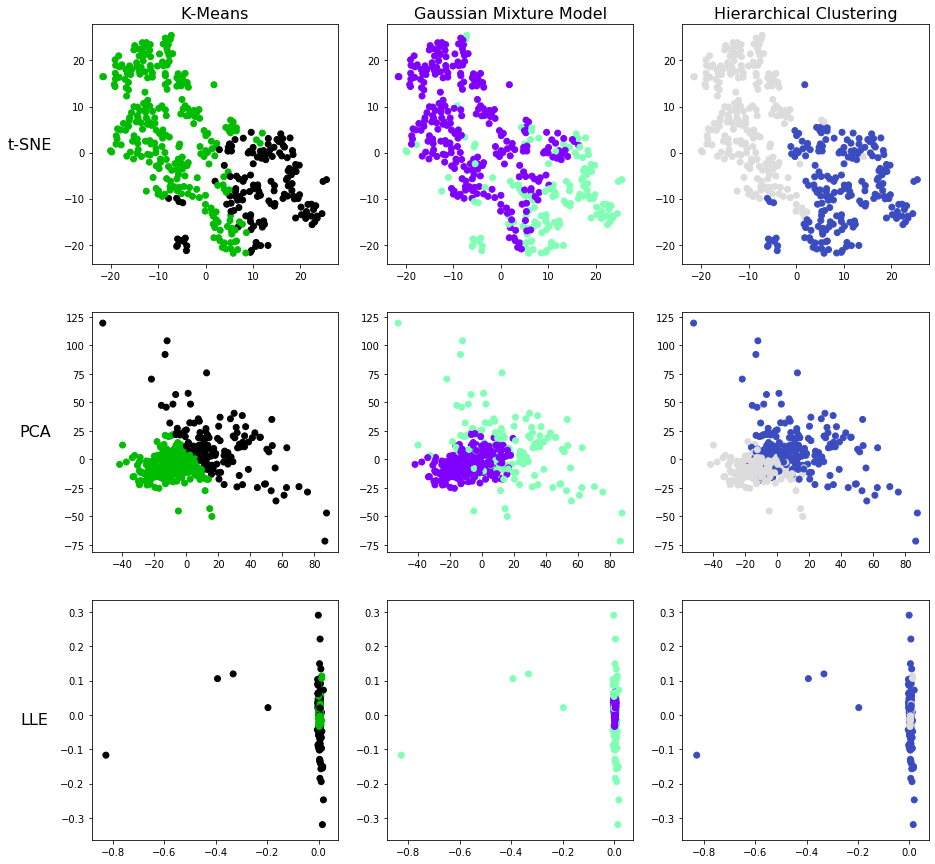

In [76]:
gk.plotManifold(poses_fs, kmeans_clusters2, gmm_clusters2,
             hier_clusters2, k=k, save='1v1s/feat_clusters_k2')

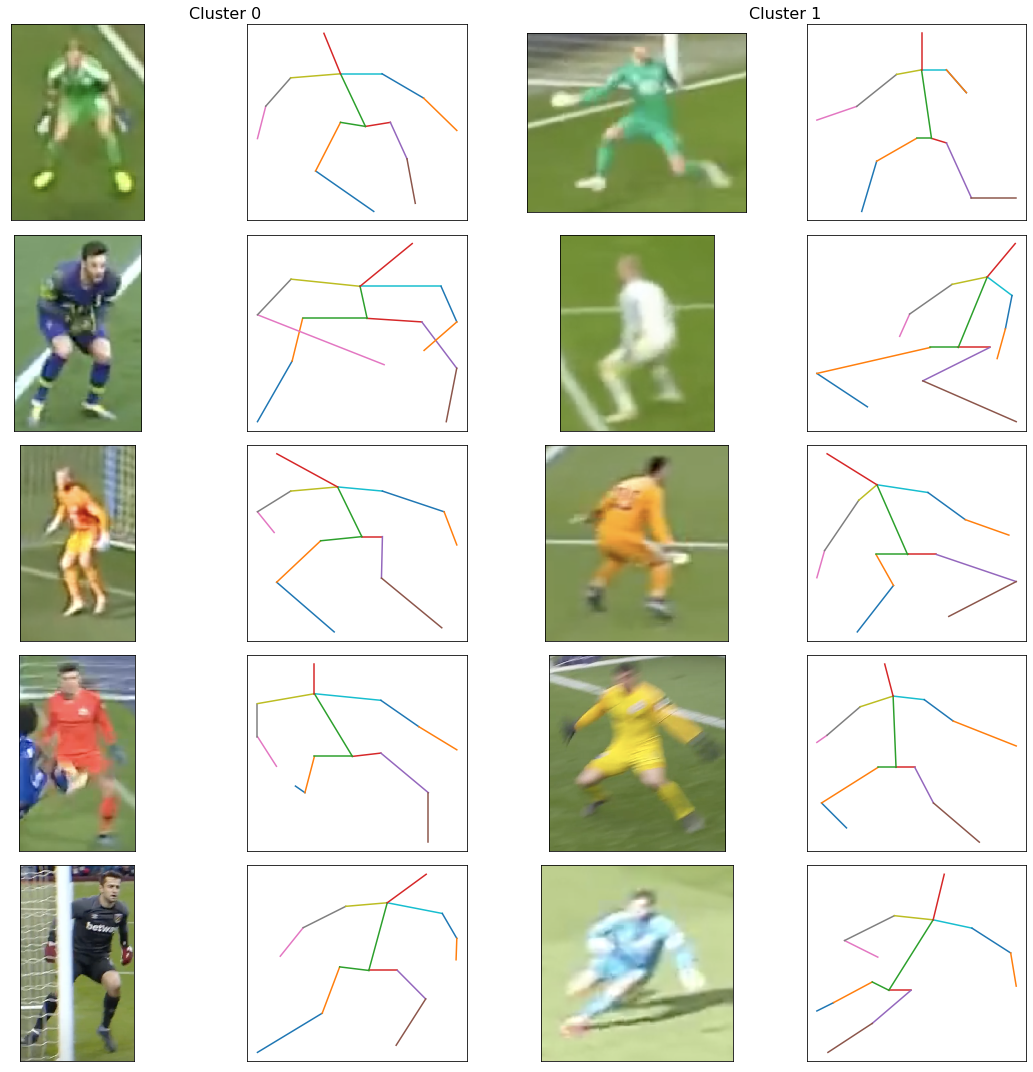

In [133]:
gk.clusterExamples(k, 5, '../1v1Data/set/', kmeans_clusters2, set_3d_cvi_clean_df, sets_3d_cvi_clean, mpii_edges, '1v1s/feat_clusters_examples_k2_test')

##### k = 3

In [82]:
k=3
kmeans_clusters3 = gk.getKMeans(poses_fs, k=k)
gmm_clusters3 = gk.getGMM(poses_fs, k=k)
hier_clusters3 = gk.getHier(poses_fs, k=k)

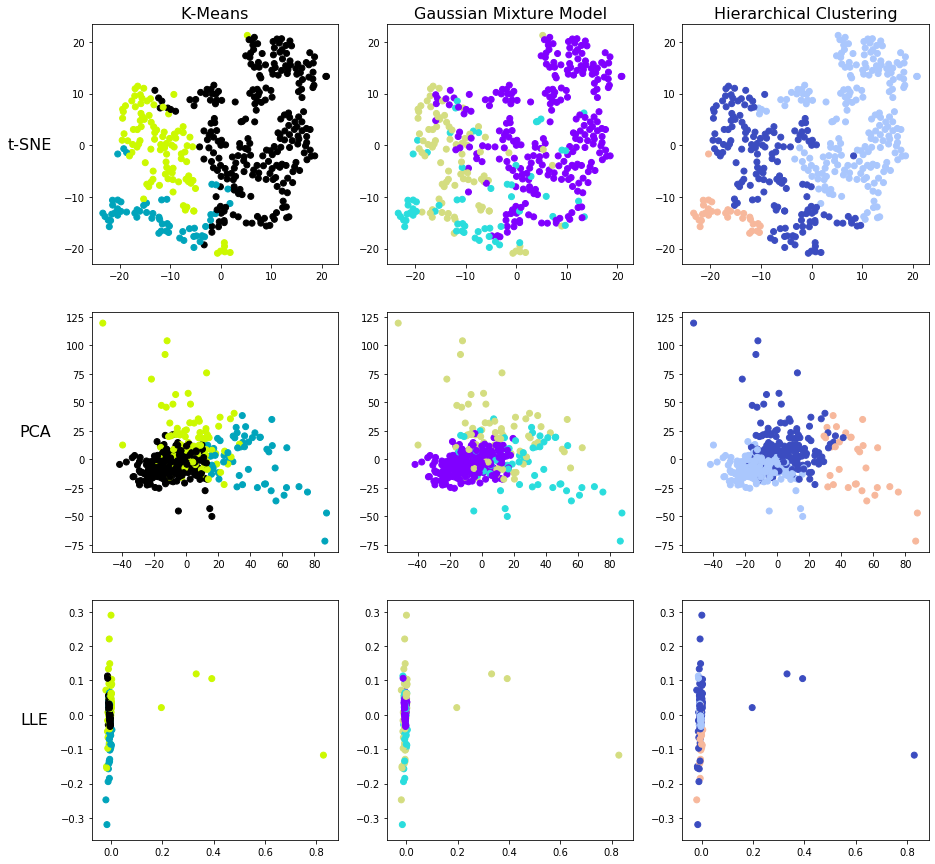

In [83]:
gk.plotManifold(poses_fs, kmeans_clusters3, gmm_clusters3,
             hier_clusters3, k=k, save='1v1s/feat_clusters_k3')

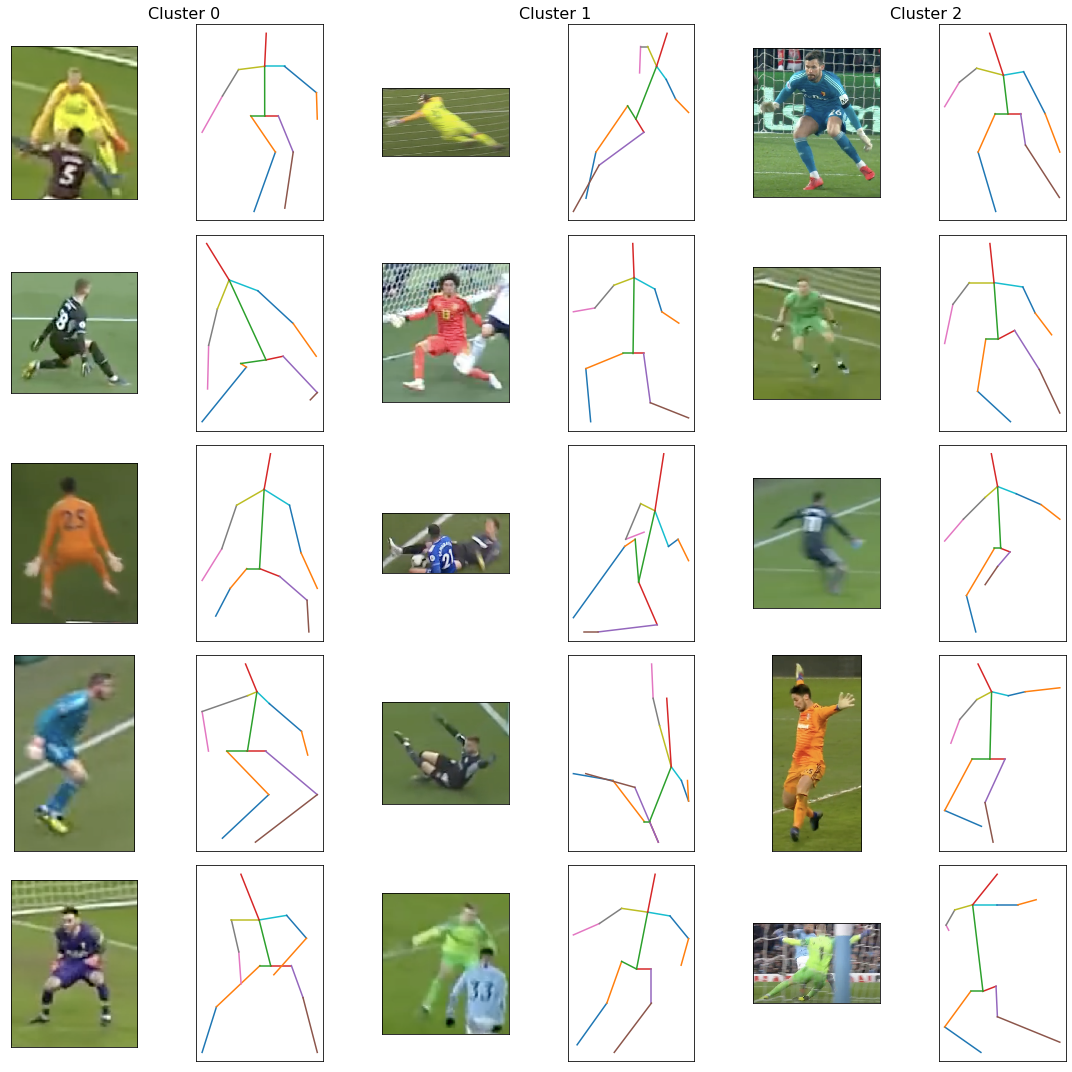

In [84]:
gk.clusterExamples(k, 5, '../1v1Data/set/', kmeans_clusters3, set_3d_cvi_clean_df, sets_3d_cvi_clean, mpii_edges, '1v1s/feat_clusters_examples_k3')

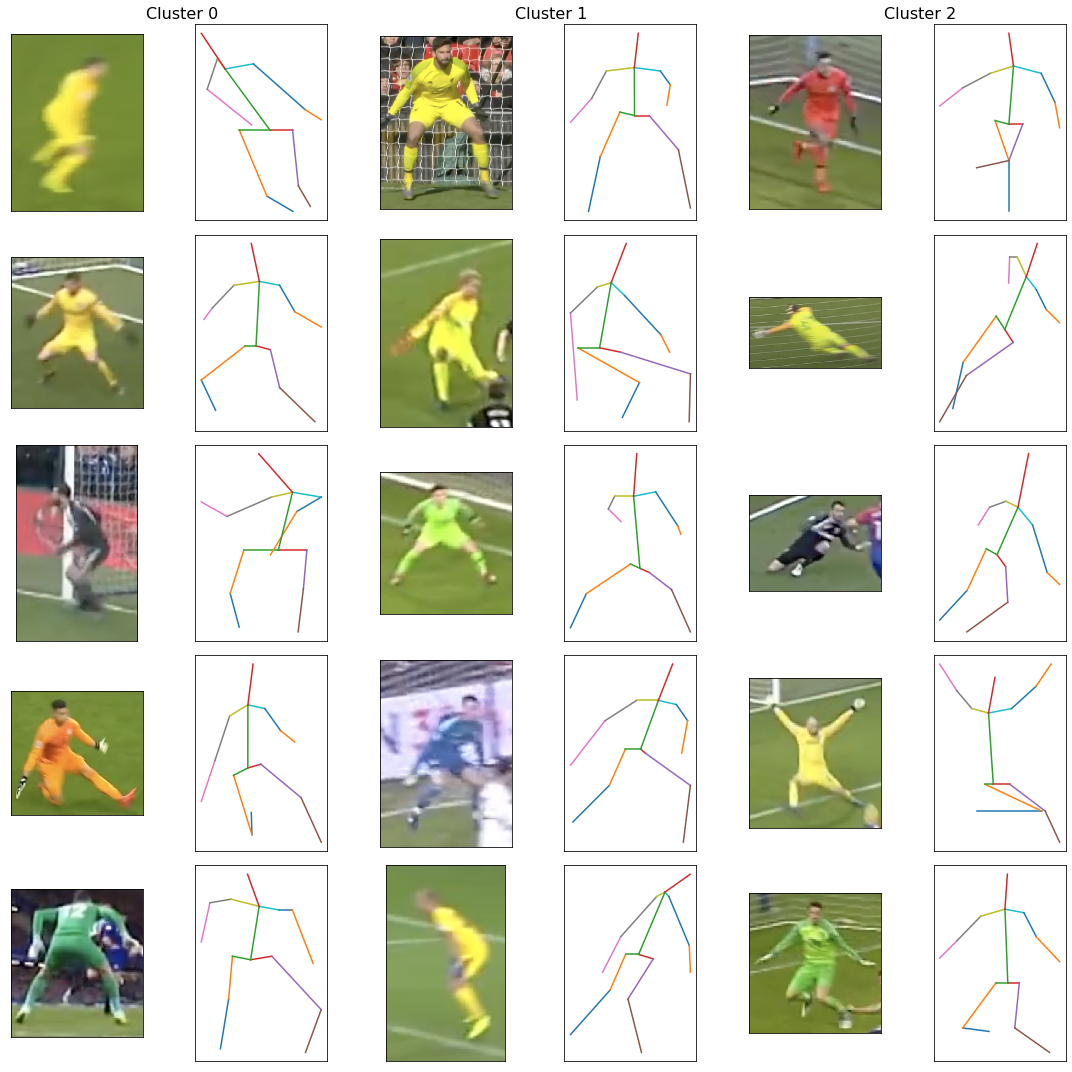

In [86]:
gk.clusterExamples(k, 5, '../1v1Data/set/', hier_clusters3, set_3d_cvi_clean_df, sets_3d_cvi_clean, mpii_edges, '1v1s/feat_clusters_hier_examples_k3')

##### k = 4

In [87]:
k=4
kmeans_clusters4 = gk.getKMeans(poses_fs, k=k)
gmm_clusters4 = gk.getGMM(poses_fs, k=k)
hier_clusters4 = gk.getHier(poses_fs, k=k)

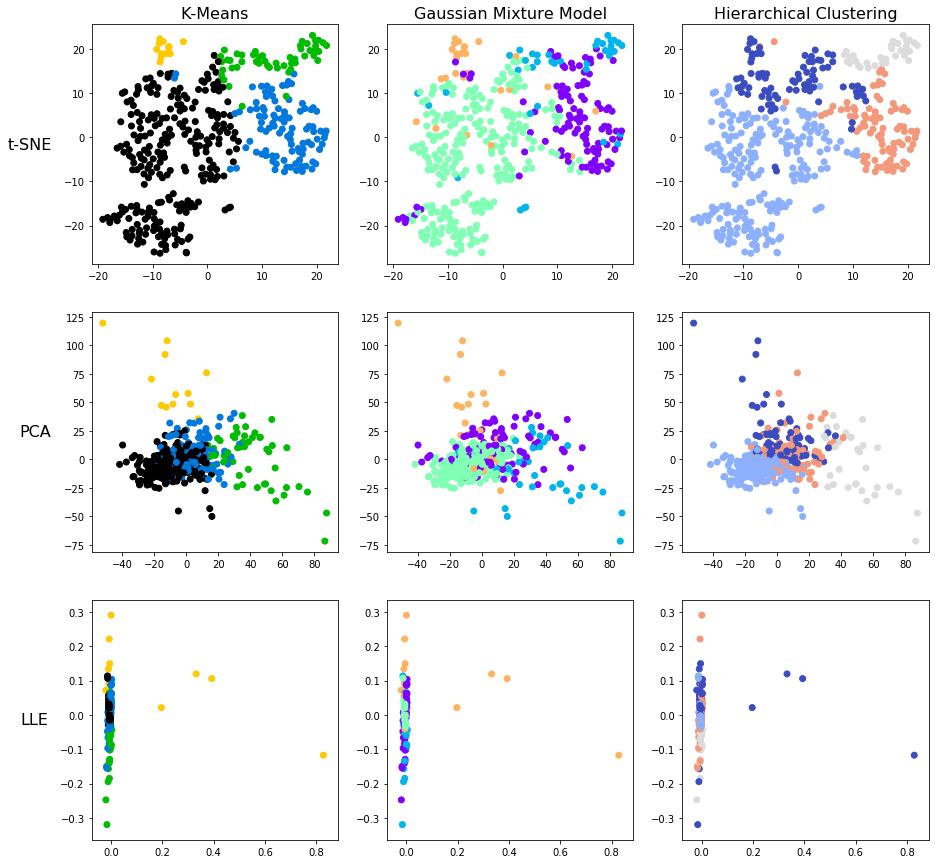

In [88]:
gk.plotManifold(poses_fs, kmeans_clusters4, gmm_clusters4,
             hier_clusters4, k=k, save='1v1s/feat_clusters_k4')

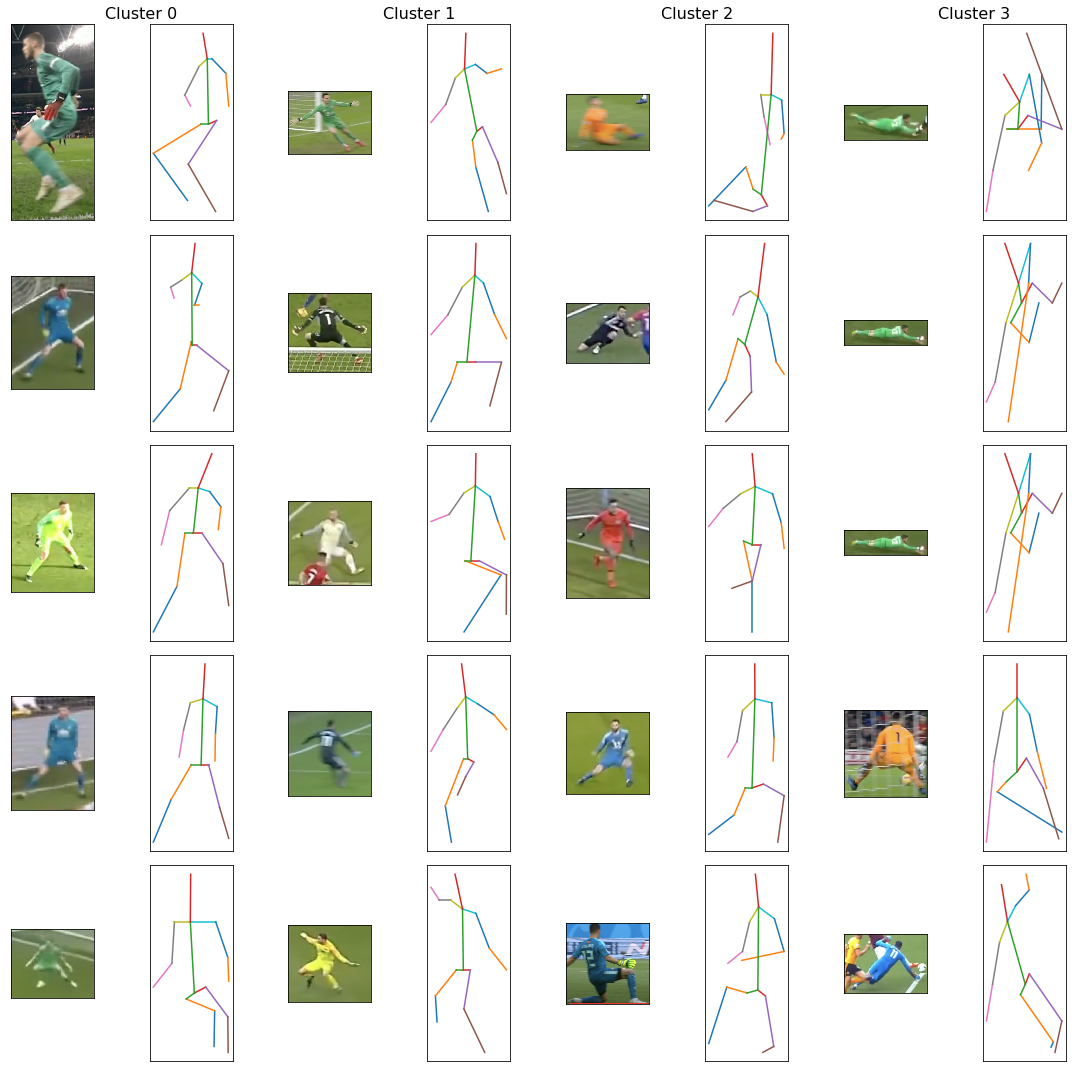

In [90]:
gk.clusterExamples(k, 5, '../1v1Data/set/', kmeans_clusters4, set_3d_cvi_clean_df, sets_3d_cvi_clean, mpii_edges, '1v1s/feat_clusters_examples_k4')

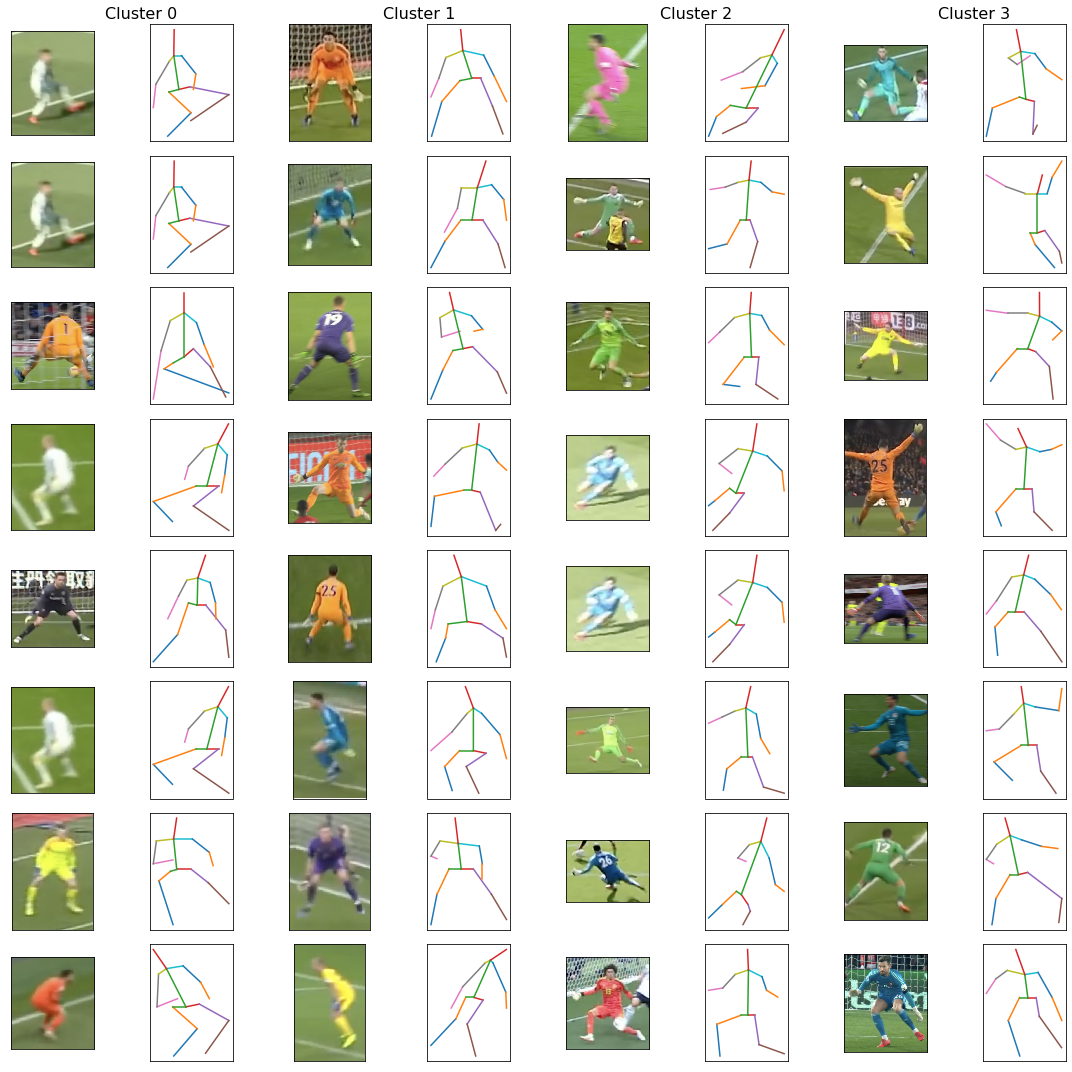

In [92]:
gk.clusterExamples(k, 8, '../1v1Data/set/', hier_clusters4, set_3d_cvi_clean_df, sets_3d_cvi_clean, mpii_edges, '1v1s/feat_clusters_hier_examples_k4')

## Expected Saves

In [2]:
from sklearn.preprocessing import StandardScaler

#### Kmeans cluster labels: 2D Body pose projection

In [151]:
set_3d_cvi_clean_df['cluster'] = kmeans_clusters4

In [152]:
#307 / 409 1v1s were on target
#Filter for on target shots (???)
on_target = (set_3d_cvi_clean_df['shot_outcome_name'] == 'Goal') | (set_3d_cvi_clean_df['shot_outcome_name'] == 'Saved')

In [153]:
features = ['shot_outcome_name','cluster','shot_angle','distance_to_goal',
            'shot_first_time','under_pressure']
ml_df = set_3d_cvi_clean_df.loc[on_target, features]
ml_df.head()

shot_outcome_name  cluster  shot_angle  distance_to_goal  shot_first_time  \
0             Saved        1   74.054604          7.280110                0   
1              Goal        1   45.000000         11.313708                0   
2             Saved        2    4.763642         12.041595                0   
3              Goal        1   45.000000          8.485281                1   
6              Goal        0   35.753887         15.402922                1   

   under_pressure  
0               0  
1               0  
2               0  
3               0  
6               0

In [156]:
#Goal = 0, Saved = 1
ml_df['shot_outcome_name'].replace({'Goal': 0, 'Saved': 1}, inplace=True)

In [157]:
#One hot encode cluster feature
ml_df = pd.get_dummies(ml_df, columns=['cluster'])
ml_df = ml_df.reset_index(drop=True)

In [141]:
#Create the test set
test_ind = np.random.choice(range(ml_df.shape[0]), int(ml_df.shape[0] * 0.4))
test_set = ml_df.loc[test_ind, :]

7

In [142]:
test_set.to_csv('xS_test.csv', index=False)

In [173]:
train_df = ml_df.drop(test_ind, axis=0).reset_index(drop=True)

In [174]:
train_df.to_csv('train.csv', index=False)

In [68]:
train_df = pd.read_csv('train.csv')

In [69]:
scaler = StandardScaler().fit(train_df[['shot_angle','distance_to_goal']])

In [70]:
train_df[['shot_angle','distance_to_goal']] = scaler.transform(train_df[['shot_angle','distance_to_goal']])

In [71]:
print(scaler.mean_)
print(scaler.var_)

[39.62428839 11.49511883]
[419.56560037  18.17304125]


In [72]:
train_df.head()

shot_outcome_name  shot_angle  distance_to_goal  shot_first_time  \
0                  1   -1.701906          0.128191                0   
1                  0    0.262444         -0.706040                1   
2                  0   -0.188954          0.916682                1   
3                  1    0.700490          0.494103                0   
4                  1   -1.156010         -0.988746                1   

   under_pressure  cluster_0  cluster_1  cluster_2  cluster_3  
0               0          0          0          1          0  
1               0          0          1          0          0  
2               0          1          0          0          0  
3               0          0          1          0          0  
4               0          0          0          0          1

In [73]:
y = train_df.pop('shot_outcome_name')
X = train_df.values

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
def val_accuracy(model, X_val, y_val):
    return np.mean(model.predict(X_val) == np.array(y_val))

##### SVM

In [77]:
#SVM 
from sklearn.svm import SVC
svm = SVC(C=1.0, kernel='rbf',probability=True).fit(X_train, y_train)

In [78]:
val_accuracy(svm, X_val, y_val)

0.813953488372093

In [79]:
train_df.head()

shot_angle  distance_to_goal  shot_first_time  under_pressure  cluster_0  \
0   -1.701906          0.128191                0               0          0   
1    0.262444         -0.706040                1               0          0   
2   -0.188954          0.916682                1               0          1   
3    0.700490          0.494103                0               0          0   
4   -1.156010         -0.988746                1               0          0   

   cluster_1  cluster_2  cluster_3  
0          0          1          0  
1          1          0          0  
2          0          0          0  
3          1          0          0  
4          0          0          1

In [87]:
scaler.transform([[10, 30]])

array([[-1.44626538,  4.34082717]])

In [89]:
#Probability of a save given the different techniques
print(svm.predict_proba([[-1.44626538,  4.34082717,0,1,1,0,0,0]])[0][1])
print(svm.predict_proba([[-1.44626538,  4.34082717,0,1,0,1,0,0]])[0][1])
print(svm.predict_proba([[-1.44626538,  4.34082717,0,1,0,0,1,0]])[0][1])
print(svm.predict_proba([[-1.44626538,  4.34082717,0,1,0,0,0,1]])[0][1])

0.3575343803943969
0.35511984764218407
0.36327960672129267
0.36004666164628857


##### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

In [32]:
lr = LogisticRegression(penalty='none', random_state=0).fit(X_train, y_train)

In [33]:
val_accuracy(lr, X_val, y_val)

0.6511627906976745

In [61]:
print(lr.predict_proba([[-1.69036666, -0.35072111,0,0,1,0,0,0]])[0][1])
print(lr.predict_proba([[-1.69036666, -0.35072111,0,0,0,1,0,0]])[0][1])
print(lr.predict_proba([[-1.69036666, -0.35072111,0,0,0,0,1,0]])[0][1])
print(lr.predict_proba([[-1.69036666, -0.35072111,0,0,0,0,0,1]])[0][1])

0.32349409587953054
0.2819859623924037
0.27456426522921135
0.30518265923705884


##### Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
rf = RandomForestClassifier(max_depth = 4, random_state=0).fit(X_train, y_train)

In [47]:
val_accuracy(rf, X_val, y_val)

0.6744186046511628

In [67]:
print(rf.predict_proba([[-1.44626538,  0.82216596,0,0,1,0,0,0]])[0][1])
print(rf.predict_proba([[-1.44626538,  0.82216596,0,0,0,1,0,0]])[0][1])
print(rf.predict_proba([[-1.44626538,  0.82216596,0,0,0,0,1,0]])[0][1])
print(rf.predict_proba([[-1.44626538,  0.82216596,0,0,0,0,0,1]])[0][1])

0.451632995677368
0.36962912016233374
0.46060258344756605
0.46302249561289366


# Pose Matching - kNN
* Build a smaller, labelled dataset, and train a kNN on it.
* To predict the type of save of one of the PL/WC saves, predict using the trained kNN.